# ABBA-BABA Test
In this notebook I performed the ABBA-BABA Test using the new outgroup allele counts <b>(see 09112019_outgroup_allele_count_phase2_dataset_creation)</b> and the new allele count dataset for the phase2.

I have used part of <b>Alistair's notebook (20150529 Admixture, introgression.ipynb)</b> on the Ag1000G github repository

-------------------

Loading modules and callsets paths:

In [1]:
%run imports.ipynb

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.33.122.18:36893 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
chromosomes = ['3L', '3R', '2L', '2R', 'X']

In [5]:
out_species = ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']

In [6]:
an_col = 'BFcol', 'GNcol', 'CIcol', 'GHcol'
an_gam = 'GHgam', 'BFgam', 'GNgam'
an_na = 'GM', 'GW'

In [7]:
calldata_out= zarr.open('../data/outgroup_alleles_phase2.zarr')

In [8]:
calldata_biallel= zarr.open('../data/phase2_biallel_allele_count.zarr')

In [9]:
metadata = pd.read_csv("samples.meta.txt", sep="\t")
metadata.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [10]:
ac_cache = dict()

def load_ac(chrom, pop):
    if (chrom, pop) in ac_cache:
        return ac_cache[chrom, pop]
    else:
        if pop in out_species:
            ac = calldata_out[chrom][pop]
        else:
            ac = calldata_biallel[chrom][pop]
            ac_cache[chrom, pop] = ac
        return ac

In [11]:
fourpop_cache = dict()

-----------------------------------------

In [34]:
def f4_analysis(chroms, A, B, C, D, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
        acd = dask.array.vstack([load_ac(chrom, D)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.blockwise_patterson_d(aca, acb, acc, acd, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f4_analys(As, Bs, Cs, Ds, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
        
    # setup output table
    tbl = [['chromosome', 'test', 'D', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    for D in Ds:
                        if C != D:
                            d, d_se, d_z, _, _ = f4_analysis(chroms, A, B, C, D, 
                                                             regions=regions, blen=blen)
                            test = 'D(%s, %s; %s, %s)' % (A, B, C, D)
                            row = [",".join(chroms), test, d, d_se, d_z]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    return tbl
    
def tbl_display(tbl):
        # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    
def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
    
    ## First Plot - Bar Plot
    x = tbl.values('D').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("Patterson's $D$ Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'D','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='D')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("Patterson's $D$ Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [35]:
A = an_gam
B = an_na
C = an_col
D = 'chri'

In [24]:
f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, GM; BFcol, chri)",-0.020,0.0035,-5.6
"3L,3R","D(GHgam, GM; GNcol, chri)",-0.039,0.0040,-9.7
"3L,3R","D(GHgam, GM; CIcol, chri)",-0.029,0.0033,-8.6
"3L,3R","D(GHgam, GM; GHcol, chri)",-0.028,0.0036,-7.7
"3L,3R","D(GHgam, GW; BFcol, chri)",-0.021,0.0044,-4.9
"3L,3R","D(GHgam, GW; GNcol, chri)",-0.045,0.0047,-9.6
"3L,3R","D(GHgam, GW; CIcol, chri)",-0.032,0.0040,-8.1
"3L,3R","D(GHgam, GW; GHcol, chri)",-0.032,0.0044,-7.2
"3L,3R","D(BFgam, GM; BFcol, chri)",-0.022,0.0027,-8.0
"3L,3R","D(BFgam, GM; GNcol, chri)",-0.041,0.0035,-11.7


[['chromosome', 'test', 'D', 'SE', 'Z'],
 ['3L,3R',
  'D(GHgam, GM; BFcol, chri)',
  -0.019717522496565842,
  0.0034987397900121085,
  -5.635607012803202],
 ['3L,3R',
  'D(GHgam, GM; GNcol, chri)',
  -0.03851444388408521,
  0.003979015682475809,
  -9.67938981836857],
 ['3L,3R',
  'D(GHgam, GM; CIcol, chri)',
  -0.028637367860472857,
  0.003319717536916889,
  -8.626447142568988],
 ['3L,3R',
  'D(GHgam, GM; GHcol, chri)',
  -0.027895496620392597,
  0.0036209088952065096,
  -7.70400400223316],
 ['3L,3R',
  'D(GHgam, GW; BFcol, chri)',
  -0.021426745995029972,
  0.004362185930496138,
  -4.911928637712372],
 ['3L,3R',
  'D(GHgam, GW; GNcol, chri)',
  -0.04459459177399662,
  0.004668029329969468,
  -9.553194425684616],
 ['3L,3R',
  'D(GHgam, GW; CIcol, chri)',
  -0.03244759451986409,
  0.004022377103220859,
  -8.06677088875684],
 ['3L,3R',
  'D(GHgam, GW; GHcol, chri)',
  -0.03179781401834116,
  0.0044285140267054934,
  -7.180244620789092],
 ['3L,3R',
  'D(BFgam, GM; BFcol, chri)',
  -0.0217

In [25]:
A = an_col
B = an_na
C = an_gam
D = 'chri'

In [23]:
f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(BFcol, GM; GHgam, chri)",-0.004,0.0064,-0.7
"3L,3R","D(BFcol, GM; BFgam, chri)",-0.007,0.0063,-1.2
"3L,3R","D(BFcol, GM; GNgam, chri)",-0.008,0.0064,-1.3
"3L,3R","D(BFcol, GW; GHgam, chri)",0.012,0.0047,2.6
"3L,3R","D(BFcol, GW; BFgam, chri)",0.009,0.0045,2.1
"3L,3R","D(BFcol, GW; GNgam, chri)",0.009,0.0045,2.0
"3L,3R","D(GNcol, GM; GHgam, chri)",-0.015,0.0064,-2.4
"3L,3R","D(GNcol, GM; BFgam, chri)",-0.019,0.0063,-3.0
"3L,3R","D(GNcol, GM; GNgam, chri)",-0.020,0.0065,-3.1
"3L,3R","D(GNcol, GW; GHgam, chri)",0.001,0.0047,0.3


In [36]:
A = an_gam
B = 'GM'
C = an_col
D = 'chri'

In [37]:
D_test = f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, GM; BFcol, chri)",-0.020,0.0035,-5.6
"3L,3R","D(GHgam, GM; GNcol, chri)",-0.039,0.0040,-9.7
"3L,3R","D(GHgam, GM; CIcol, chri)",-0.029,0.0033,-8.6
"3L,3R","D(GHgam, GM; GHcol, chri)",-0.028,0.0036,-7.7
"3L,3R","D(BFgam, GM; BFcol, chri)",-0.022,0.0027,-8.0
"3L,3R","D(BFgam, GM; GNcol, chri)",-0.041,0.0035,-11.7
"3L,3R","D(BFgam, GM; CIcol, chri)",-0.031,0.0026,-11.8
"3L,3R","D(BFgam, GM; GHcol, chri)",-0.030,0.0028,-10.7
"3L,3R","D(GNgam, GM; BFcol, chri)",-0.023,0.0027,-8.5
"3L,3R","D(GNgam, GM; GNcol, chri)",-0.042,0.0035,-12.1


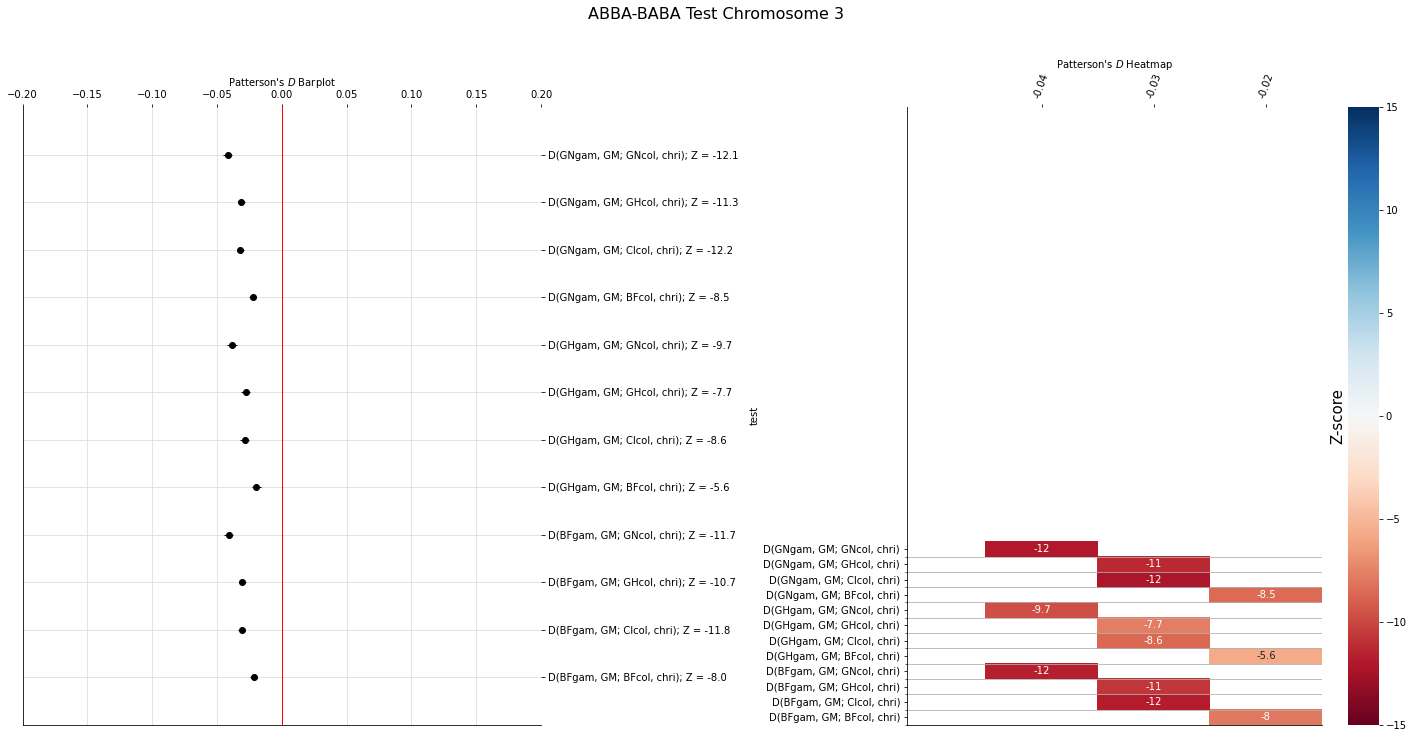

In [38]:
tbl_d_plot(D_test, 'ABBA-BABA Test Chromosome 3')

In [39]:
A = an_gam
B = 'GW'
C = an_col
D = 'chri'

In [42]:
D_test = f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, GW; BFcol, chri)",-0.021,0.0044,-4.9
"3L,3R","D(GHgam, GW; GNcol, chri)",-0.045,0.0047,-9.6
"3L,3R","D(GHgam, GW; CIcol, chri)",-0.032,0.0040,-8.1
"3L,3R","D(GHgam, GW; GHcol, chri)",-0.032,0.0044,-7.2
"3L,3R","D(BFgam, GW; BFcol, chri)",-0.023,0.0035,-6.8
"3L,3R","D(BFgam, GW; GNcol, chri)",-0.047,0.0041,-11.4
"3L,3R","D(BFgam, GW; CIcol, chri)",-0.035,0.0032,-10.7
"3L,3R","D(BFgam, GW; GHcol, chri)",-0.034,0.0036,-9.7
"3L,3R","D(GNgam, GW; BFcol, chri)",-0.024,0.0033,-7.3
"3L,3R","D(GNgam, GW; GNcol, chri)",-0.048,0.0040,-11.8


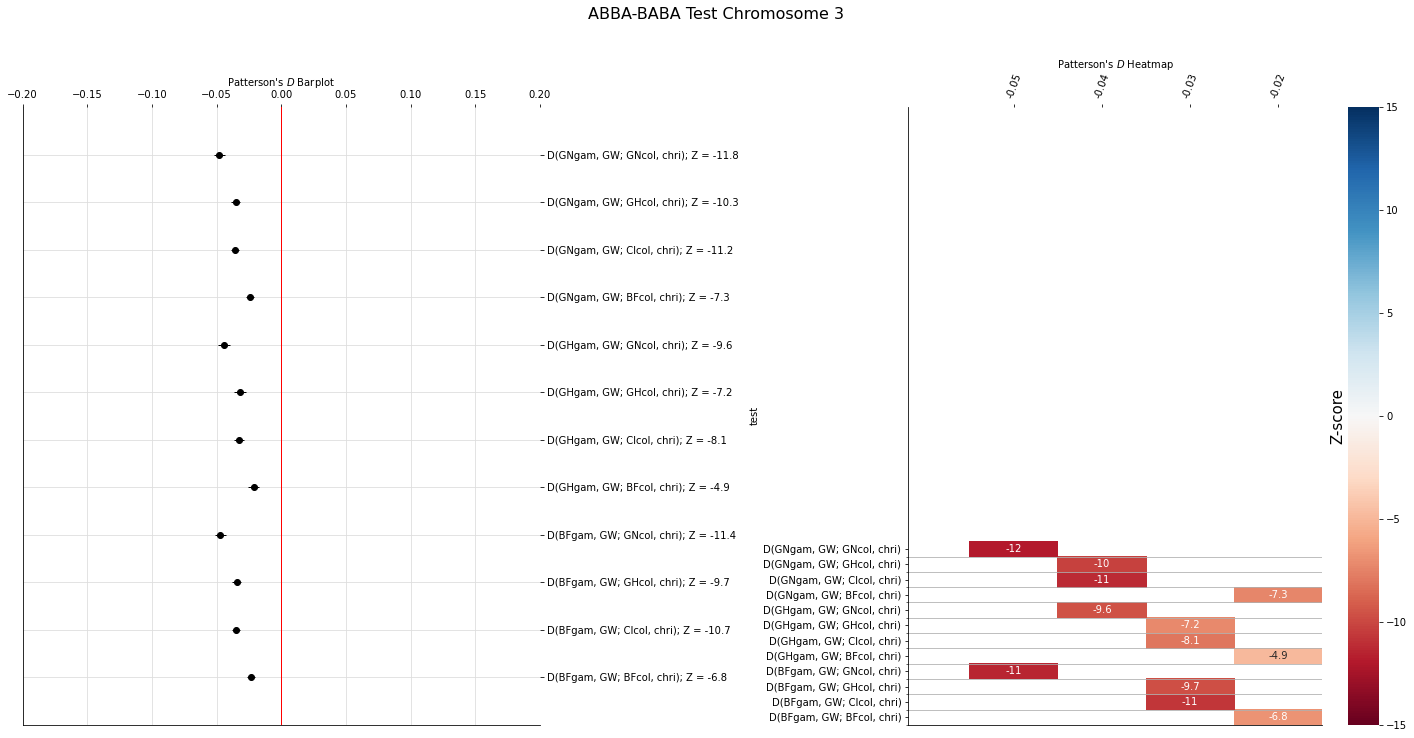

In [43]:
tbl_d_plot(D_test, 'ABBA-BABA Test Chromosome 3')

--------------------------------------

## Kenya Situation
There are 4 possible hypothesis:

1) ((An.gam , An.col), KE, O) = 0 ?

2) ((An.gam , KE), An.col, O) = 0 ?

3) ((An.col, KE), An.gam, O) = 0 ?

4) None of theese.. Kenya hybrid?

In [13]:
A = an_col
B = an_gam
C =  'KE'
D = 'chri'

In [14]:
f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(AOcol, GHgam; KE, chri)",0.057,0.0048,11.7
"3L,3R","D(AOcol, CMgam; KE, chri)",0.058,0.0053,11.1
"3L,3R","D(AOcol, BFgam; KE, chri)",0.058,0.0051,11.4
"3L,3R","D(AOcol, GNgam; KE, chri)",0.059,0.0052,11.3
"3L,3R","D(AOcol, GQgam; KE, chri)",0.052,0.0052,9.9
"3L,3R","D(AOcol, UGgam; KE, chri)",0.046,0.0054,8.6
"3L,3R","D(AOcol, GAgam; KE, chri)",0.035,0.0053,6.7
"3L,3R","D(AOcol, FRgam; KE, chri)",-0.032,0.0075,-4.3
"3L,3R","D(BFcol, GHgam; KE, chri)",0.043,0.0063,6.8
"3L,3R","D(BFcol, CMgam; KE, chri)",0.044,0.0069,6.4


In [17]:
A = an_gam
B = 'KE'
C =  an_col
D = 'chri'

In [18]:
f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, KE; AOcol, chri)",-0.046,0.0082,-5.6
"3L,3R","D(GHgam, KE; BFcol, chri)",-0.049,0.0080,-6.2
"3L,3R","D(GHgam, KE; GNcol, chri)",-0.048,0.0077,-6.2
"3L,3R","D(GHgam, KE; CIcol, chri)",-0.053,0.0079,-6.7
"3L,3R","D(GHgam, KE; GHcol, chri)",-0.057,0.0084,-6.7
"3L,3R","D(CMgam, KE; AOcol, chri)",-0.049,0.0090,-5.5
"3L,3R","D(CMgam, KE; BFcol, chri)",-0.055,0.0089,-6.1
"3L,3R","D(CMgam, KE; GNcol, chri)",-0.054,0.0085,-6.3
"3L,3R","D(CMgam, KE; CIcol, chri)",-0.059,0.0088,-6.7
"3L,3R","D(CMgam, KE; GHcol, chri)",-0.063,0.0093,-6.8


In [19]:
A = an_col
B = 'KE'
C =  an_gam
D = 'chri'

In [20]:
f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(AOcol, KE; GHgam, chri)",0.011,0.0058,1.9
"3L,3R","D(AOcol, KE; CMgam, chri)",0.009,0.0059,1.6
"3L,3R","D(AOcol, KE; BFgam, chri)",0.011,0.0058,1.9
"3L,3R","D(AOcol, KE; GNgam, chri)",0.011,0.0059,1.8
"3L,3R","D(AOcol, KE; GQgam, chri)",0.017,0.0055,3.1
"3L,3R","D(AOcol, KE; UGgam, chri)",0.001,0.0053,0.2
"3L,3R","D(AOcol, KE; GAgam, chri)",0.016,0.0045,3.5
"3L,3R","D(AOcol, KE; FRgam, chri)",-0.064,0.0055,-11.8
"3L,3R","D(BFcol, KE; GHgam, chri)",-0.006,0.0035,-1.8
"3L,3R","D(BFcol, KE; CMgam, chri)",-0.011,0.0035,-3.0


In [21]:
A = an_gam
B = an_col
C = 'KE'
D = 'chri'

In [22]:
f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, AOcol; KE, chri)",-0.057,0.0048,-11.7
"3L,3R","D(GHgam, BFcol; KE, chri)",-0.043,0.0063,-6.8
"3L,3R","D(GHgam, GNcol; KE, chri)",-0.030,0.0056,-5.4
"3L,3R","D(GHgam, CIcol; KE, chri)",-0.043,0.0059,-7.4
"3L,3R","D(GHgam, GHcol; KE, chri)",-0.048,0.0064,-7.6
"3L,3R","D(CMgam, AOcol; KE, chri)",-0.058,0.0053,-11.1
"3L,3R","D(CMgam, BFcol; KE, chri)",-0.044,0.0069,-6.4
"3L,3R","D(CMgam, GNcol; KE, chri)",-0.031,0.0061,-5.1
"3L,3R","D(CMgam, CIcol; KE, chri)",-0.045,0.0064,-6.9
"3L,3R","D(CMgam, GHcol; KE, chri)",-0.050,0.0069,-7.1


-------------------------------

## Guinea-Bissau Situation
There are 4 possible hypothesis:

1) ((An.gam , An.col), GW, O) = 0 ?

2) ((An.gam , GW), An.col, O) = 0 ?

3) ((An.col, GW), An.gam, O) = 0 ?

4) None of theese.. GW hybrid?

In [26]:
A = an_gam
B = an_col
C = 'GW'
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, AOcol; GW, chri)",-0.036,0.0045,-8.0
"3L,3R","D(GHgam, BFcol; GW, chri)",-0.037,0.0037,-9.8
"3L,3R","D(GHgam, GNcol; GW, chri)",-0.050,0.0043,-11.7
"3L,3R","D(GHgam, CIcol; GW, chri)",-0.045,0.0037,-12.0
"3L,3R","D(GHgam, GHcol; GW, chri)",-0.045,0.0040,-11.4
"3L,3R","D(CMgam, AOcol; GW, chri)",-0.036,0.0043,-8.4
"3L,3R","D(CMgam, BFcol; GW, chri)",-0.037,0.0036,-10.3
"3L,3R","D(CMgam, GNcol; GW, chri)",-0.050,0.0042,-12.1
"3L,3R","D(CMgam, CIcol; GW, chri)",-0.045,0.0036,-12.5
"3L,3R","D(CMgam, GHcol; GW, chri)",-0.046,0.0039,-11.7


In [27]:
A = an_col
B = an_gam
C = 'GW'
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(AOcol, GHgam; GW, chri)",0.036,0.0045,8.0
"3L,3R","D(AOcol, CMgam; GW, chri)",0.036,0.0043,8.4
"3L,3R","D(AOcol, BFgam; GW, chri)",0.035,0.0043,8.1
"3L,3R","D(AOcol, GNgam; GW, chri)",0.035,0.0043,8.2
"3L,3R","D(AOcol, GQgam; GW, chri)",0.035,0.0044,7.8
"3L,3R","D(AOcol, UGgam; GW, chri)",0.038,0.0043,9.0
"3L,3R","D(AOcol, GAgam; GW, chri)",0.032,0.0039,8.2
"3L,3R","D(AOcol, FRgam; GW, chri)",0.042,0.0044,9.6
"3L,3R","D(BFcol, GHgam; GW, chri)",0.037,0.0037,9.8
"3L,3R","D(BFcol, CMgam; GW, chri)",0.037,0.0036,10.3


In [28]:
A = an_gam
B = 'GW'
C = an_col
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, GW; AOcol, chri)",-0.003,0.0047,-0.6
"3L,3R","D(GHgam, GW; BFcol, chri)",-0.021,0.0046,-4.4
"3L,3R","D(GHgam, GW; GNcol, chri)",-0.045,0.0050,-9.0
"3L,3R","D(GHgam, GW; CIcol, chri)",-0.032,0.0042,-7.6
"3L,3R","D(GHgam, GW; GHcol, chri)",-0.031,0.0047,-6.6
"3L,3R","D(CMgam, GW; AOcol, chri)",-0.006,0.0043,-1.3
"3L,3R","D(CMgam, GW; BFcol, chri)",-0.026,0.0039,-6.6
"3L,3R","D(CMgam, GW; GNcol, chri)",-0.051,0.0046,-11.0
"3L,3R","D(CMgam, GW; CIcol, chri)",-0.038,0.0036,-10.5
"3L,3R","D(CMgam, GW; GHcol, chri)",-0.037,0.0040,-9.3


In [29]:
A = 'GW'
B = an_gam
C = an_col
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GW, GHgam; AOcol, chri)",0.003,0.0047,0.6
"3L,3R","D(GW, GHgam; BFcol, chri)",0.021,0.0046,4.4
"3L,3R","D(GW, GHgam; GNcol, chri)",0.045,0.0050,9.0
"3L,3R","D(GW, GHgam; CIcol, chri)",0.032,0.0042,7.6
"3L,3R","D(GW, GHgam; GHcol, chri)",0.031,0.0047,6.6
"3L,3R","D(GW, CMgam; AOcol, chri)",0.006,0.0043,1.3
"3L,3R","D(GW, CMgam; BFcol, chri)",0.026,0.0039,6.6
"3L,3R","D(GW, CMgam; GNcol, chri)",0.051,0.0046,11.0
"3L,3R","D(GW, CMgam; CIcol, chri)",0.038,0.0036,10.5
"3L,3R","D(GW, CMgam; GHcol, chri)",0.037,0.0040,9.3


In [30]:
A = 'GW'
B = an_col
C = an_gam
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GW, AOcol; GHgam, chri)",-0.033,0.0039,-8.5
"3L,3R","D(GW, AOcol; CMgam, chri)",-0.031,0.0043,-7.1
"3L,3R","D(GW, AOcol; BFgam, chri)",-0.031,0.0042,-7.3
"3L,3R","D(GW, AOcol; GNgam, chri)",-0.030,0.0042,-7.1
"3L,3R","D(GW, AOcol; GQgam, chri)",-0.043,0.0041,-10.4
"3L,3R","D(GW, AOcol; UGgam, chri)",-0.036,0.0040,-9.2
"3L,3R","D(GW, AOcol; GAgam, chri)",-0.055,0.0033,-16.8
"3L,3R","D(GW, AOcol; FRgam, chri)",-0.054,0.0039,-13.9
"3L,3R","D(GW, BFcol; GHgam, chri)",-0.016,0.0029,-5.7
"3L,3R","D(GW, BFcol; CMgam, chri)",-0.011,0.0027,-4.1


-------------------------------

## Gambia Situation
There are 4 possible hypothesis:

1) ((An.gam , An.col), GM, O) = 0 ?

2) ((An.gam , GM), An.col, O) = 0 ?

3) ((An.col, GM), An.gam, O) = 0 ?

4) None of theese.. GM hybrid?

In [31]:
A = an_gam
B = an_col
C = 'GM'
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, AOcol; GM, chri)",-0.020,0.0064,-3.1
"3L,3R","D(GHgam, BFcol; GM, chri)",-0.019,0.0050,-3.8
"3L,3R","D(GHgam, GNcol; GM, chri)",-0.028,0.0051,-5.4
"3L,3R","D(GHgam, CIcol; GM, chri)",-0.025,0.0052,-4.8
"3L,3R","D(GHgam, GHcol; GM, chri)",-0.025,0.0053,-4.8
"3L,3R","D(CMgam, AOcol; GM, chri)",-0.020,0.0061,-3.3
"3L,3R","D(CMgam, BFcol; GM, chri)",-0.019,0.0047,-4.1
"3L,3R","D(CMgam, GNcol; GM, chri)",-0.028,0.0048,-5.8
"3L,3R","D(CMgam, CIcol; GM, chri)",-0.025,0.0049,-5.1
"3L,3R","D(CMgam, GHcol; GM, chri)",-0.025,0.0050,-5.0


In [32]:
A = an_col
B = an_gam
C = 'GM'
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(AOcol, GHgam; GM, chri)",0.020,0.0064,3.1
"3L,3R","D(AOcol, CMgam; GM, chri)",0.020,0.0061,3.3
"3L,3R","D(AOcol, BFgam; GM, chri)",0.019,0.0061,3.0
"3L,3R","D(AOcol, GNgam; GM, chri)",0.018,0.0063,2.9
"3L,3R","D(AOcol, GQgam; GM, chri)",0.020,0.0060,3.3
"3L,3R","D(AOcol, UGgam; GM, chri)",0.024,0.0057,4.1
"3L,3R","D(AOcol, GAgam; GM, chri)",0.019,0.0054,3.5
"3L,3R","D(AOcol, FRgam; GM, chri)",0.030,0.0056,5.3
"3L,3R","D(BFcol, GHgam; GM, chri)",0.019,0.0050,3.8
"3L,3R","D(BFcol, CMgam; GM, chri)",0.019,0.0047,4.1


In [33]:
A = an_gam
B = 'GM'
C = an_col
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GHgam, GM; AOcol, chri)",-0.003,0.0039,-0.8
"3L,3R","D(GHgam, GM; BFcol, chri)",-0.019,0.0037,-5.1
"3L,3R","D(GHgam, GM; GNcol, chri)",-0.039,0.0043,-9.1
"3L,3R","D(GHgam, GM; CIcol, chri)",-0.028,0.0035,-8.0
"3L,3R","D(GHgam, GM; GHcol, chri)",-0.027,0.0039,-7.1
"3L,3R","D(CMgam, GM; AOcol, chri)",-0.006,0.0036,-1.7
"3L,3R","D(CMgam, GM; BFcol, chri)",-0.025,0.0032,-7.7
"3L,3R","D(CMgam, GM; GNcol, chri)",-0.045,0.0040,-11.2
"3L,3R","D(CMgam, GM; CIcol, chri)",-0.034,0.0030,-11.3
"3L,3R","D(CMgam, GM; GHcol, chri)",-0.034,0.0033,-10.2


In [34]:
A = 'GM'
B = an_gam
C = an_col
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GM, GHgam; AOcol, chri)",0.003,0.0039,0.8
"3L,3R","D(GM, GHgam; BFcol, chri)",0.019,0.0037,5.1
"3L,3R","D(GM, GHgam; GNcol, chri)",0.039,0.0043,9.1
"3L,3R","D(GM, GHgam; CIcol, chri)",0.028,0.0035,8.0
"3L,3R","D(GM, GHgam; GHcol, chri)",0.027,0.0039,7.1
"3L,3R","D(GM, CMgam; AOcol, chri)",0.006,0.0036,1.7
"3L,3R","D(GM, CMgam; BFcol, chri)",0.025,0.0032,7.7
"3L,3R","D(GM, CMgam; GNcol, chri)",0.045,0.0040,11.2
"3L,3R","D(GM, CMgam; CIcol, chri)",0.034,0.0030,11.3
"3L,3R","D(GM, CMgam; GHcol, chri)",0.034,0.0033,10.2


In [35]:
A = 'GM'
B = an_col
C = an_gam
D = 'chri'

f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(15000000, 41000000), slice(1000000, 37000000)))

chromosome,test,D,SE,Z
"3L,3R","D(GM, AOcol; GHgam, chri)",-0.017,0.0062,-2.8
"3L,3R","D(GM, AOcol; CMgam, chri)",-0.014,0.0064,-2.1
"3L,3R","D(GM, AOcol; BFgam, chri)",-0.014,0.0064,-2.2
"3L,3R","D(GM, AOcol; GNgam, chri)",-0.013,0.0065,-2.0
"3L,3R","D(GM, AOcol; GQgam, chri)",-0.028,0.0059,-4.7
"3L,3R","D(GM, AOcol; UGgam, chri)",-0.021,0.0058,-3.7
"3L,3R","D(GM, AOcol; GAgam, chri)",-0.042,0.0047,-8.9
"3L,3R","D(GM, AOcol; FRgam, chri)",-0.042,0.0044,-9.4
"3L,3R","D(GM, BFcol; GHgam, chri)",-0.000,0.0041,-0.0
"3L,3R","D(GM, BFcol; CMgam, chri)",0.005,0.0042,1.3


-----------------------------------

In [40]:
#this is the function that perform the test
def f4_analysis(chrom, A, B, C, D, blen=100000, plot=False, ax=None):
    
    key = (chrom, A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = load_ac(chrom, A)
        acb = load_ac(chrom, B)
        acc = load_ac(chrom, C)
        acd = load_ac(chrom, D)

        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.blockwise_patterson_d(aca, acb, acc, acd, blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

#this is the function that give me to display multiple tests on a table
def f4_analyses(As, Bs, Cs, Ds, chroms=chromosomes, blen=100000):
    
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
        
    # setup output table
    tbl = [['chromosome', 'test', 'D', 'SE', 'Z']]
    for chrom in chroms:
        for A in As:
            for B in Bs:
                if A != B:
                    for C in Cs:
                        for D in Ds:
                            if C != D:
                                d, d_se, d_z, _, _ = f4_analysis(chrom, A, B, C, D, blen=blen)
                                test = 'D(%s, %s; %s, %s)' % (A, B, C, D)
                                row = [chrom, test, d, d_se, d_z]
                                tbl += [row]
    
    # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    

In [41]:
chromosomes = ['3L','3R']

## Guinea-Bissau

In [43]:
A = 'GW'
B = an_col
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(GW, AOcol; GHgam, chri)",-0.051,0.0043,-11.9
3L,"D(GW, AOcol; CMgam, chri)",-0.054,0.0047,-11.4
3L,"D(GW, AOcol; BFgam, chri)",-0.052,0.0046,-11.1
3L,"D(GW, AOcol; GNgam, chri)",-0.052,0.0045,-11.4
3L,"D(GW, AOcol; GQgam, chri)",-0.070,0.0057,-12.2
3L,"D(GW, AOcol; UGgam, chri)",-0.058,0.0051,-11.4
3L,"D(GW, AOcol; GAgam, chri)",-0.076,0.0059,-12.9
3L,"D(GW, AOcol; FRgam, chri)",-0.072,0.0063,-11.5
3L,"D(GW, BFcol; GHgam, chri)",-0.032,0.0069,-4.6
3L,"D(GW, BFcol; CMgam, chri)",-0.032,0.0071,-4.5


## Gambia

In [44]:
A = 'GM'
B = an_col
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(GM, AOcol; GHgam, chri)",-0.040,0.0046,-8.8
3L,"D(GM, AOcol; CMgam, chri)",-0.043,0.0048,-9.0
3L,"D(GM, AOcol; BFgam, chri)",-0.041,0.0048,-8.6
3L,"D(GM, AOcol; GNgam, chri)",-0.041,0.0046,-8.9
3L,"D(GM, AOcol; GQgam, chri)",-0.061,0.0055,-11.1
3L,"D(GM, AOcol; UGgam, chri)",-0.048,0.0049,-9.8
3L,"D(GM, AOcol; GAgam, chri)",-0.067,0.0054,-12.4
3L,"D(GM, AOcol; FRgam, chri)",-0.063,0.0058,-10.8
3L,"D(GM, BFcol; GHgam, chri)",-0.021,0.0060,-3.6
3L,"D(GM, BFcol; CMgam, chri)",-0.021,0.0061,-3.4


-------------------------

## Kenya

In [55]:
A = an_col
B = an_gam
C = 'KE'
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(AOcol, GHgam; KE, chri)",0.017,0.0044,3.8
3L,"D(AOcol, CMgam; KE, chri)",0.018,0.0043,4.2
3L,"D(AOcol, BFgam; KE, chri)",0.019,0.0043,4.5
3L,"D(AOcol, GNgam; KE, chri)",0.021,0.0042,4.9
3L,"D(AOcol, GQgam; KE, chri)",0.014,0.0040,3.6
3L,"D(AOcol, UGgam; KE, chri)",0.008,0.0048,1.7
3L,"D(AOcol, GAgam; KE, chri)",0.003,0.0037,0.9
3L,"D(AOcol, FRgam; KE, chri)",-0.054,0.0064,-8.5
3L,"D(BFcol, GHgam; KE, chri)",0.002,0.0042,0.4
3L,"D(BFcol, CMgam; KE, chri)",0.003,0.0046,0.6


What about the geography? Is chromosome 3 coastal-related for Kenya? 
Comparison between coastal populations and inland populations

In [26]:
A = 'AOcol', 'GNcol', 'CIcol', 'GHcol', 'GM', 'GW', 'FRgam', 'GQgam',  'GAgam'
B = 'GHgam', 'CMgam', 'BFgam', 'GNgam', 'UGgam', 'BFcol'
C = 'KE'
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(AOcol, GHgam; KE, chri)",0.017,0.0044,3.8
3L,"D(AOcol, CMgam; KE, chri)",0.018,0.0043,4.2
3L,"D(AOcol, BFgam; KE, chri)",0.019,0.0043,4.5
3L,"D(AOcol, GNgam; KE, chri)",0.021,0.0042,4.9
3L,"D(AOcol, UGgam; KE, chri)",0.008,0.0048,1.7
3L,"D(AOcol, BFcol; KE, chri)",0.016,0.0044,3.6
3L,"D(GNcol, GHgam; KE, chri)",-0.007,0.0053,-1.4
3L,"D(GNcol, CMgam; KE, chri)",-0.006,0.0056,-1.1
3L,"D(GNcol, BFgam; KE, chri)",-0.005,0.0055,-0.9
3L,"D(GNcol, GNgam; KE, chri)",-0.003,0.0054,-0.6


-------------------

## The Angolan situation:

In [17]:
an_col = 'BFcol', 'GNcol', 'CIcol', 'GHcol'


In [18]:
A = 'AOcol'
B = an_col
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(AOcol, BFcol; GHgam, chri)",0.020,0.0049,4.2
3L,"D(AOcol, BFcol; CMgam, chri)",0.023,0.0043,5.4
3L,"D(AOcol, BFcol; BFgam, chri)",0.020,0.0049,4.1
3L,"D(AOcol, BFcol; GNgam, chri)",0.021,0.0045,4.7
3L,"D(AOcol, BFcol; GQgam, chri)",0.034,0.0039,8.6
3L,"D(AOcol, BFcol; UGgam, chri)",0.026,0.0040,6.6
3L,"D(AOcol, BFcol; GAgam, chri)",0.039,0.0034,11.2
3L,"D(AOcol, BFcol; FRgam, chri)",0.031,0.0041,7.5
3L,"D(AOcol, GNcol; GHgam, chri)",0.032,0.0044,7.2
3L,"D(AOcol, GNcol; CMgam, chri)",0.036,0.0040,9.2


In [19]:
A = an_col
B = 'AOcol'
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(BFcol, AOcol; GHgam, chri)",-0.020,0.0049,-4.2
3L,"D(BFcol, AOcol; CMgam, chri)",-0.023,0.0043,-5.4
3L,"D(BFcol, AOcol; BFgam, chri)",-0.020,0.0049,-4.1
3L,"D(BFcol, AOcol; GNgam, chri)",-0.021,0.0045,-4.7
3L,"D(BFcol, AOcol; GQgam, chri)",-0.034,0.0039,-8.6
3L,"D(BFcol, AOcol; UGgam, chri)",-0.026,0.0040,-6.6
3L,"D(BFcol, AOcol; GAgam, chri)",-0.039,0.0034,-11.2
3L,"D(BFcol, AOcol; FRgam, chri)",-0.031,0.0041,-7.5
3L,"D(GNcol, AOcol; GHgam, chri)",-0.032,0.0044,-7.2
3L,"D(GNcol, AOcol; CMgam, chri)",-0.036,0.0040,-9.2


In [20]:
A = an_col
B = an_gam
C = 'AOcol'
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(BFcol, GHgam; AOcol, chri)",0.053,0.0082,6.5
3L,"D(BFcol, CMgam; AOcol, chri)",0.055,0.0084,6.6
3L,"D(BFcol, BFgam; AOcol, chri)",0.057,0.0084,6.7
3L,"D(BFcol, GNgam; AOcol, chri)",0.058,0.0084,6.9
3L,"D(BFcol, GQgam; AOcol, chri)",0.036,0.0065,5.5
3L,"D(BFcol, UGgam; AOcol, chri)",0.054,0.0079,6.8
3L,"D(BFcol, GAgam; AOcol, chri)",0.030,0.0066,4.6
3L,"D(BFcol, FRgam; AOcol, chri)",0.046,0.0070,6.5
3L,"D(GNcol, GHgam; AOcol, chri)",0.042,0.0079,5.3
3L,"D(GNcol, CMgam; AOcol, chri)",0.044,0.0081,5.4


------------

In [44]:
an_col = 'AOcol', 'BFcol', 'GNcol', 'CIcol', 'GHcol'
an_gam = 'GHgam', 'CMgam', 'BFgam', 'GNgam', 'GQgam', 'UGgam', 'FRgam'
an_na = 'KE', 'GM', 'GW'

In [45]:
A = an_col
B = 'GAgam'
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(AOcol, GAgam; GHgam, chri)",-0.024,0.0104,-2.3
3L,"D(AOcol, GAgam; CMgam, chri)",-0.028,0.0095,-3.0
3L,"D(AOcol, GAgam; BFgam, chri)",-0.024,0.0096,-2.5
3L,"D(AOcol, GAgam; GNgam, chri)",-0.025,0.0098,-2.5
3L,"D(AOcol, GAgam; GQgam, chri)",-0.014,0.0069,-2.1
3L,"D(AOcol, GAgam; UGgam, chri)",-0.023,0.0079,-2.9
3L,"D(AOcol, GAgam; FRgam, chri)",-0.030,0.0050,-6.0
3L,"D(BFcol, GAgam; GHgam, chri)",-0.043,0.0069,-6.2
3L,"D(BFcol, GAgam; CMgam, chri)",-0.049,0.0065,-7.6
3L,"D(BFcol, GAgam; BFgam, chri)",-0.042,0.0065,-6.5


In [46]:
A = 'GAgam'
B = an_col
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(GAgam, AOcol; GHgam, chri)",0.024,0.0104,2.3
3L,"D(GAgam, AOcol; CMgam, chri)",0.028,0.0095,3.0
3L,"D(GAgam, AOcol; BFgam, chri)",0.024,0.0096,2.5
3L,"D(GAgam, AOcol; GNgam, chri)",0.025,0.0098,2.5
3L,"D(GAgam, AOcol; GQgam, chri)",0.014,0.0069,2.1
3L,"D(GAgam, AOcol; UGgam, chri)",0.023,0.0079,2.9
3L,"D(GAgam, AOcol; FRgam, chri)",0.030,0.0050,6.0
3L,"D(GAgam, BFcol; GHgam, chri)",0.043,0.0069,6.2
3L,"D(GAgam, BFcol; CMgam, chri)",0.049,0.0065,7.6
3L,"D(GAgam, BFcol; BFgam, chri)",0.042,0.0065,6.5


## merus test

In [59]:
A = an_col
B = an_gam
C = 'KE'
D = 'meru'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(AOcol, GHgam; KE, meru)",0.023,0.0053,4.4
3L,"D(AOcol, CMgam; KE, meru)",0.024,0.0053,4.4
3L,"D(AOcol, BFgam; KE, meru)",0.025,0.0054,4.6
3L,"D(AOcol, GNgam; KE, meru)",0.026,0.0054,4.8
3L,"D(AOcol, GQgam; KE, meru)",0.020,0.0047,4.3
3L,"D(AOcol, UGgam; KE, meru)",0.010,0.0062,1.7
3L,"D(AOcol, GAgam; KE, meru)",0.006,0.0049,1.2
3L,"D(AOcol, FRgam; KE, meru)",-0.071,0.0079,-9.0
3L,"D(BFcol, GHgam; KE, meru)",0.007,0.0059,1.3
3L,"D(BFcol, CMgam; KE, meru)",0.008,0.0062,1.3


In [62]:
A = 'GW'
B = an_col
C = an_gam
D = 'meru'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(GW, AOcol; GHgam, meru)",-0.066,0.0061,-10.8
3L,"D(GW, AOcol; CMgam, meru)",-0.069,0.0065,-10.5
3L,"D(GW, AOcol; BFgam, meru)",-0.066,0.0065,-10.2
3L,"D(GW, AOcol; GNgam, meru)",-0.066,0.0063,-10.5
3L,"D(GW, AOcol; GQgam, meru)",-0.091,0.0077,-11.9
3L,"D(GW, AOcol; UGgam, meru)",-0.075,0.0071,-10.6
3L,"D(GW, AOcol; GAgam, meru)",-0.100,0.0080,-12.4
3L,"D(GW, AOcol; FRgam, meru)",-0.095,0.0085,-11.2
3L,"D(GW, BFcol; GHgam, meru)",-0.046,0.0099,-4.7
3L,"D(GW, BFcol; CMgam, meru)",-0.045,0.0100,-4.6


In [63]:
A = 'GM'
B = an_col
C = an_gam
D = 'meru'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(GM, AOcol; GHgam, meru)",-0.051,0.0061,-8.3
3L,"D(GM, AOcol; CMgam, meru)",-0.054,0.0063,-8.5
3L,"D(GM, AOcol; BFgam, meru)",-0.051,0.0063,-8.1
3L,"D(GM, AOcol; GNgam, meru)",-0.051,0.0061,-8.4
3L,"D(GM, AOcol; GQgam, meru)",-0.079,0.0072,-10.9
3L,"D(GM, AOcol; UGgam, meru)",-0.061,0.0064,-9.5
3L,"D(GM, AOcol; GAgam, meru)",-0.087,0.0070,-12.5
3L,"D(GM, AOcol; FRgam, meru)",-0.082,0.0075,-11.0
3L,"D(GM, BFcol; GHgam, meru)",-0.031,0.0082,-3.8
3L,"D(GM, BFcol; CMgam, meru)",-0.030,0.0084,-3.6


-----------------------------------

In [66]:
A = an_col
B = 'AOcol'
C = an_gam
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(BFcol, AOcol; GHgam, chri)",-0.020,0.0049,-4.2
3L,"D(BFcol, AOcol; CMgam, chri)",-0.023,0.0043,-5.4
3L,"D(BFcol, AOcol; BFgam, chri)",-0.020,0.0049,-4.1
3L,"D(BFcol, AOcol; GNgam, chri)",-0.021,0.0045,-4.7
3L,"D(BFcol, AOcol; GQgam, chri)",-0.034,0.0039,-8.6
3L,"D(BFcol, AOcol; UGgam, chri)",-0.026,0.0040,-6.6
3L,"D(BFcol, AOcol; GAgam, chri)",-0.039,0.0034,-11.2
3L,"D(BFcol, AOcol; FRgam, chri)",-0.031,0.0041,-7.5
3L,"D(GNcol, AOcol; GHgam, chri)",-0.032,0.0044,-7.2
3L,"D(GNcol, AOcol; CMgam, chri)",-0.036,0.0040,-9.2


In [70]:
A = an_gam
B = an_col
C = 'AOcol'
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(GHgam, AOcol; AOcol, chri)",-0.325,0.0089,-36.7
3L,"D(GHgam, BFcol; AOcol, chri)",-0.053,0.0082,-6.5
3L,"D(GHgam, GNcol; AOcol, chri)",-0.042,0.0079,-5.3
3L,"D(GHgam, CIcol; AOcol, chri)",-0.053,0.0081,-6.6
3L,"D(GHgam, GHcol; AOcol, chri)",-0.056,0.0084,-6.6
3L,"D(CMgam, AOcol; AOcol, chri)",-0.327,0.0088,-37.0
3L,"D(CMgam, BFcol; AOcol, chri)",-0.055,0.0084,-6.6
3L,"D(CMgam, GNcol; AOcol, chri)",-0.044,0.0081,-5.4
3L,"D(CMgam, CIcol; AOcol, chri)",-0.055,0.0082,-6.8
3L,"D(CMgam, GHcol; AOcol, chri)",-0.058,0.0085,-6.8


-------------

In [70]:
A = an_col
B = an_gam
C = 'KE'
D = 'chri'

f4_analyses(A, B, C, D, chromosomes)

chromosome,test,D,SE,Z
3L,"D(AOcol, GHgam; KE, chri)",0.017,0.0044,3.8
3L,"D(AOcol, CMgam; KE, chri)",0.018,0.0043,4.2
3L,"D(AOcol, BFgam; KE, chri)",0.019,0.0043,4.5
3L,"D(AOcol, GNgam; KE, chri)",0.021,0.0042,4.9
3L,"D(AOcol, GQgam; KE, chri)",0.014,0.0040,3.6
3L,"D(AOcol, UGgam; KE, chri)",0.008,0.0048,1.7
3L,"D(AOcol, GAgam; KE, chri)",0.003,0.0037,0.9
3L,"D(AOcol, FRgam; KE, chri)",-0.054,0.0064,-8.5
3L,"D(BFcol, GHgam; KE, chri)",0.002,0.0042,0.4
3L,"D(BFcol, CMgam; KE, chri)",0.003,0.0046,0.6


In [63]:
#these are the function for visualizing the test along the genome    
def f4_plot(chrom, A, B, C, D, blen=100000, ax=None, ylim=(-.6, .6)):
    d, d_se, d_z, d_vb, d_vj = f4_analysis(chrom, A, B, C, D, blen=blen)

    # load variant positions
    pos = callset_biallel[chrom]['variants']['POS'][:]

    block_starts = allel.moving_statistic(pos, statistic=np.min, size=blen)
    block_stops = allel.moving_statistic(pos, statistic=np.max, size=blen)
    block_widths = block_stops - block_starts

    if ax is None:
        fig, ax = subplots(figsize=(14, 6))
    ax.bar(block_starts, d_vb, width=block_widths, linewidth=0)
    ax.axhline(0, color='k', linestyle='--')
    ax.set_ylabel('D', rotation=0, ha='center', va='center')
    ax.set_ylim(*ylim)
    
    return ax

In [64]:
A = 'AOcol'
B = 'GAgam'
C = 'KE'
D = 'chri'

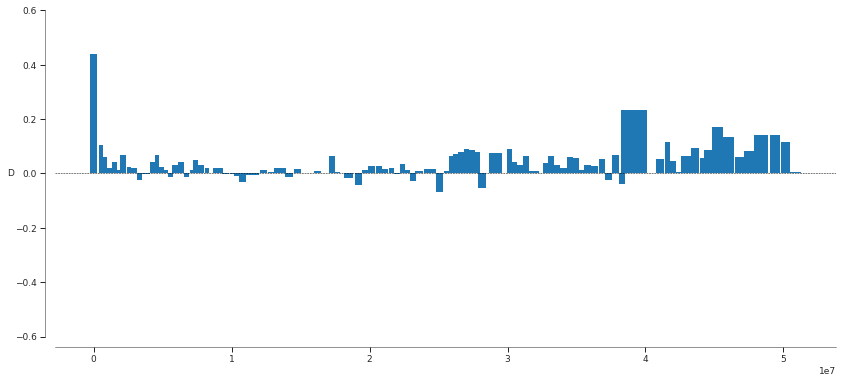

In [65]:
f4_plot('3R', A,B,C,D)

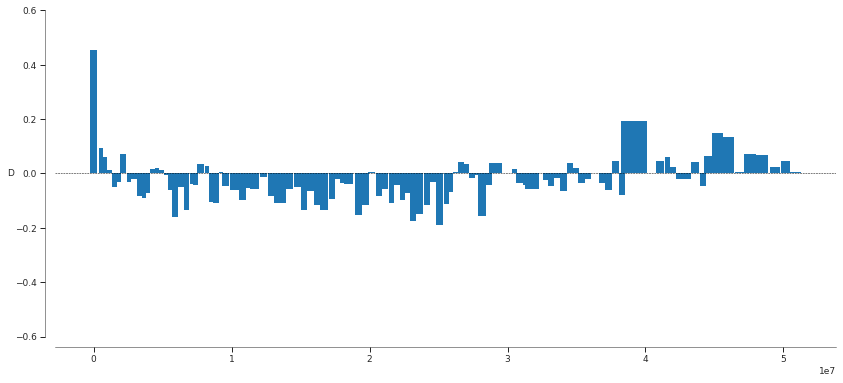

In [68]:
A = 'AOcol'
B = 'FRgam'
C = 'KE'
D = 'chri'
f4_plot('3R', A,B,C,D)

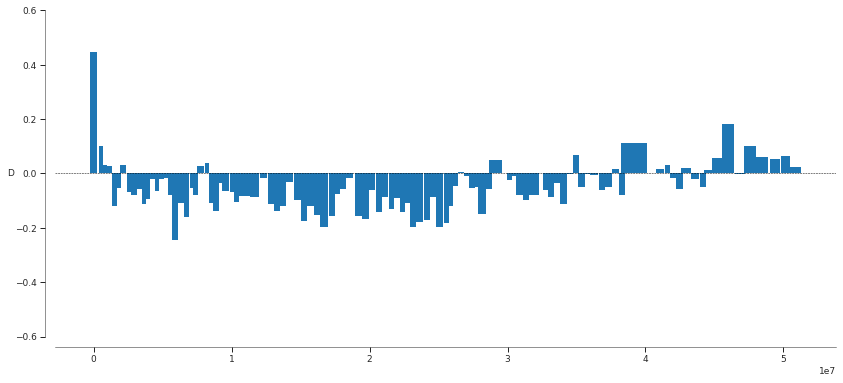

In [69]:
A = 'GNcol'
B = 'FRgam'
C = 'KE'
D = 'chri'
f4_plot('3R', A,B,C,D)